# Qiskit 102: Building a Qiskit pattern workflow

## Step 1: Map classical problem to quantum circuits and observables

##### Paper based on: https://arxiv.org/abs/1411.4028

In [1]:
import rustworkx as rx
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RZZGate, RXGate

def max_cut_hamiltonian(graph: rx.PyGraph) -> SparsePauliOp:
    """
    THIS COMES FROM THE PAPER ABOVE, based on eq. (11)


    In terms "" corresponds to the identity component, represented by an empty string acting on [] , no qubits.
    Then, the identity compoenent is the product of 1/2 times the number of edges.

    Then, the Puali operators are added the the list. "ZZ" corresponds to the pauli operators on j and k vertices

    graph.num_edges() = number of edges in the graph
    graph.num_modes() = number of vertices in the graph
    """
    terms = [["", [], 0.5 * graph.num_edges()]]
    for edge in graph.edge_list():
        terms.append(["ZZ", edge, -0.5])
    return SparsePauliOp.from_sparse_list(terms, num_qubits=graph.num_nodes())

SparsePauliOp(['IIIII', 'IIIZZ', 'IIZIZ', 'IIZZI', 'IZIIZ', 'IZIZI', 'IZZII', 'ZIIIZ', 'ZIIZI', 'ZZIII'],
              coeffs=[ 4.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j, -0.5+0.j, -0.5+0.j])
EdgeList[(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 3)]


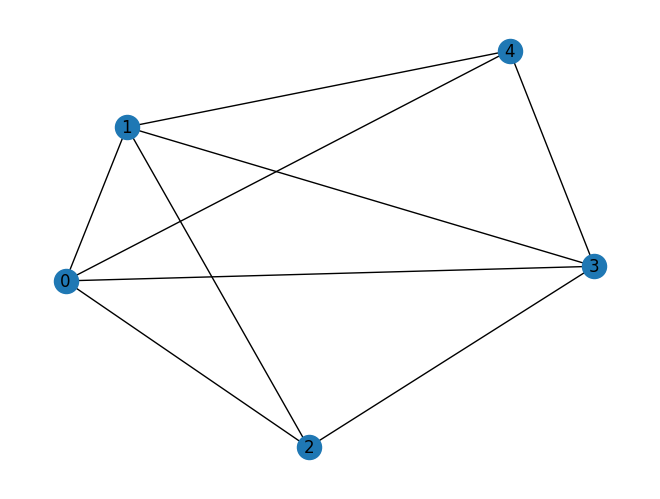

In [2]:
from rustworkx.visualization import mpl_draw

n_qubits = 5        # Number of edges defined in num_modes
probability = 0.8  # Probability for adding an edge between any two nodes/vertices

graph = rx.undirected_gnp_random_graph(num_nodes=n_qubits, probability=probability)

observable = max_cut_hamiltonian(graph)

print(observable)
print(graph.edge_list())
mpl_draw(graph, with_labels=True)
###########################################################################################
#           THE CORRESPONDENCE BETWEEN THE OPERATORS AND EDGES IS THE FOLLOWING:          #
#                                                                                         #
#     'AAAAA' --> '43210', where 4 corresponds to node ID=4, 3 to node ID=3 and so on.    #
#                                                                                         # 
#           Then,   'IIIII' = no edge                                                     #
#                   'IIIZZ' = edge between node ID=0 and node ID=1 --> (0,1)              #
#                   'ZIZII' = edge between node ID=2 and node ID=4 --> (2,4)              #
###########################################################################################

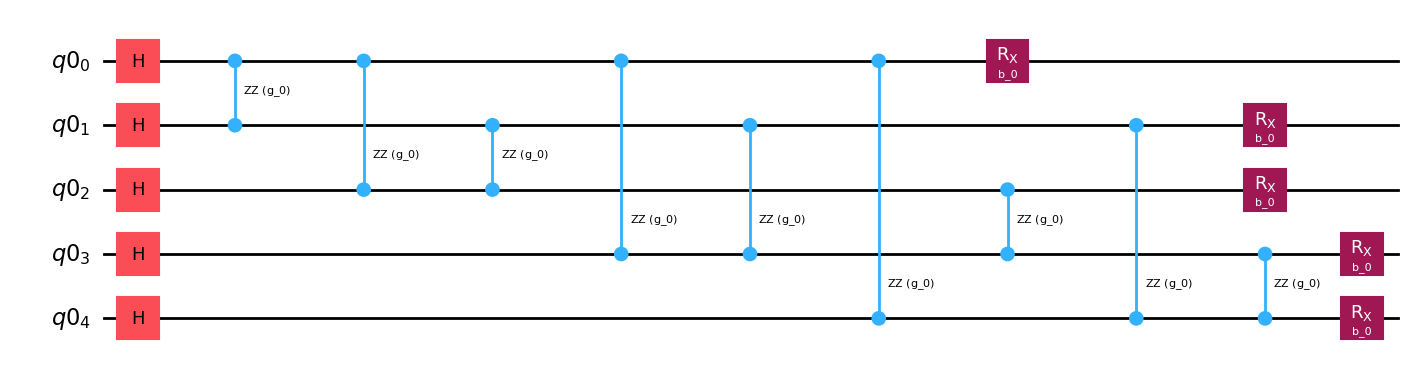

In [3]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter

def qaoa_circuit(graph: rx.PyGraph, p: int) -> QuantumCircuit:
    """
    betas:      Angles of the single qubit rotations --> based on eq. (4)
    gammas:     Angles of the edges --> based on eq. (2)
    """
    betas = [Parameter(f"b_{i}") for i in range(p)]
    gammas = [Parameter(f"g_{i}") for i in range(p)]
    qubits = QuantumRegister(graph.num_nodes())     # Number of qubits = number of vertices in the graph
    circuit = QuantumCircuit(qubits)

    # We now create the uniform superposition over the computational basis states, based on eq. (5)
    # This is done by calling the Hadamard gate on all qubits
    circuit.h(qubits)
    
    # Then the angle dependent quantum state is defined (on eq. (6))
    for beta, gamma in zip(betas, gammas):
        # Now for each edge in the graph, we add a RZZ gate, which implements exp(-i \theta / 2 * X \cross X) --> both qubits undergo an X-rotation 
        # simultaneously, with their rotations being dependent one each other.
        for (i, j) in graph.edge_list():
            circuit.append(RZZGate(gamma), [qubits[i], qubits[j]])
        # Now for each node in the graph, we add a RX gate, which implements exp(-i \theta / 2 * X) --> rotating the qubit state around x-axis by \theta
        for q in qubits:
            circuit.append(RXGate(beta), [q])
    return circuit

p=1

circuit = qaoa_circuit(graph, p=p)
circuit.draw("mpl")

## Step 2: Optimize problem for execution on quantum hardware

In [4]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeSherbrooke()

pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    # initial_layout=[0, 1, 2, 3, 4],
)

isa_circuit = pass_manager.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

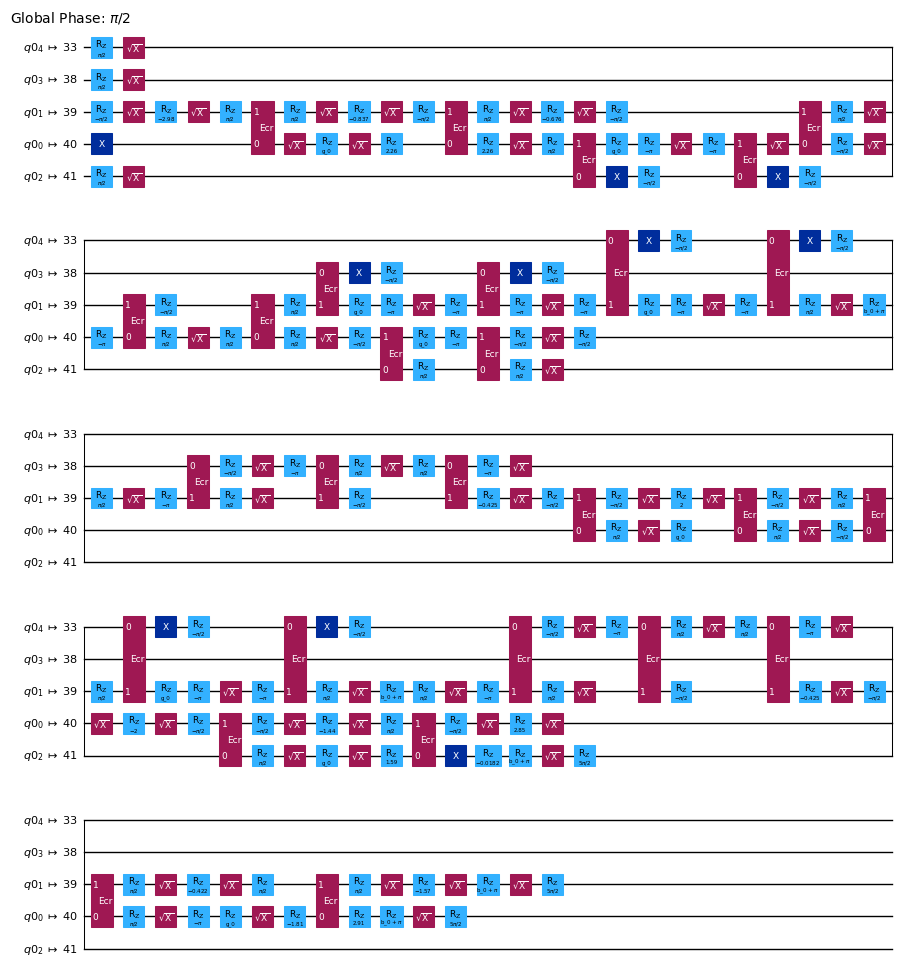

In [5]:
isa_circuit.draw("mpl", idle_wires=False, scale=0.5)

## Cannot work with these package!
Need to install Graphviz but cannot

In [ ]:
from qiskit.visualization import plot_circuit_layout, plot_error_map

plot_error_map(backend, figsize=(20,20))

plot_circuit_layout(isa_circuit, backend)

## Step 3: Execute circuits using Qiskit Primitives

# LEFT THE VIDEO HERE, MIN 28:02

In [9]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np

rng = np.random.default_rng()
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)


estimator = Estimator(mode=backend)

pub = (isa_circuit, isa_observable, params)
job = estimator.run([pub])

In [10]:
result = job.result()
pub_result = result[0]
expectation_val = float(pub_result.data.evs)
expectation_val

3.8935546875

In [ ]:
from qiskit_ibm_runtime import Session
import scipy.optimize


def f(x: np.ndarray, estimator: Estimator) -> float:
    pub = (isa_circuit, isa_observable, x)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    val = -float(pub_result.data.evs)
    print(f"Objective function value: {val}")
    return val


with Session(backend=backend):
    estimator = Estimator(mode=backend)
    result = scipy.optimize.minimize(
        f, params, args=(estimator,), method="COBYLA", options=dict(maxiter=5)
    )

Objective function value: -3.965087890625
Objective function value: -4.986083984375
Objective function value: -4.41259765625


In [118]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# params = result.x

sampler = Sampler(mode=backend)

circuit_with_meas = circuit.copy()
circuit_with_meas.measure_all()
isa_circuit = pass_manager.run(circuit_with_meas)

pub = (isa_circuit, params)
job = sampler.run([pub])
result = job.result()
pub_result = result[0]
pub_result

SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=5>)), metadata={'shots': 1024, 'circuit_metadata': {}})

## Step 4: Postprocess results into classical format

In [119]:
counts = pub_result.data.meas.get_counts()

bitstring = max(counts, key=lambda x: counts[x])

In [120]:
def cut_size(bitstring: str, graph: rx.PyGraph) -> int:
    return sum(bitstring[-i-1] != bitstring[-j-1] for i, j in graph.edge_list())

cut_size(bitstring, graph)

5

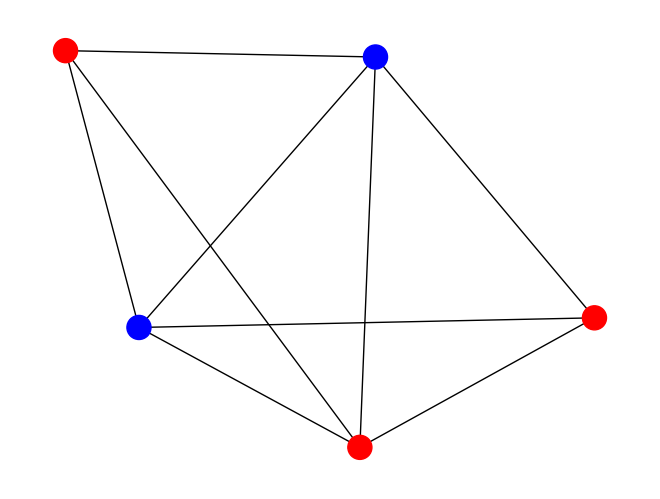

In [121]:
colors = ["red" if b == "0" else "blue" for b in bitstring]

mpl_draw(graph, node_color=colors)